In [76]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import seaborn as sns
%matplotlib inline
from os import listdir

import keras
from sklearn.model_selection import train_test_split

## Explore

---

In [2]:
data_dir = r"../../data/"
image_dir = r"../../data/train_images/"

In [3]:
df_train = pd.read_csv(str(data_dir + 'train.csv'))
df_train.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [4]:
shape = df_train.shape
number_of_nans = df_train.isnull().sum().sum()
number_of_images = len(listdir(image_dir))


print(f"Shape: {shape}")
print(f"NaNs: {number_of_nans}")
print(f"Number of images in dir: {number_of_images}")

Shape: (7095, 3)
NaNs: 0
Number of images in dir: 12568


In [5]:
len(listdir(image_dir))

12568

<AxesSubplot:xlabel='ClassId', ylabel='count'>

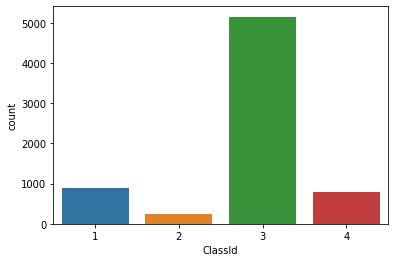

In [6]:
sns.countplot(x='ClassId', data=df_train)

In [7]:
n_all = len(listdir(image_dir))
n_defects = df_train[df_train.ClassId.isin([1,2,3,4])].ClassId.count()
n_1 = df_train[df_train.ClassId.isin([1])].ClassId.count()
n_2 = df_train[df_train.ClassId.isin([2])].ClassId.count()
n_3 = df_train[df_train.ClassId.isin([3])].ClassId.count()
n_4 = df_train[df_train.ClassId.isin([4])].ClassId.count()
print(f"Not defective: {(n_all - n_defects) / n_all  * 100 :.2f} %")
print(f"Defect 1: {n_1 / n_all * 100:.2f} % ({n_1 / n_defects * 100:.2f} %)")
print(f"Defect 2: {n_2 / n_all * 100:.2f} % ({n_2 / n_defects * 100:.2f} %)")
print(f"Defect 3: {n_3 / n_all * 100:.2f} % ({n_3 / n_defects * 100:.2f} %)")
print(f"Defect 4: {n_4 / n_all * 100:.2f} % ({n_4 / n_defects * 100:.2f} %)")

Not defective: 43.55 %
Defect 1: 7.14 % (12.64 %)
Defect 2: 1.97 % (3.48 %)
Defect 3: 40.98 % (72.59 %)
Defect 4: 6.37 % (11.29 %)


In [68]:
list_of_images = listdir(image_dir)
df_train_complete = {'ImageId': [],
                     'ClassId': [],
                    'mask_1': [],
                    'mask_2': [],
                    'mask_3': [],
                    'mask_4': []}
for image_id in list_of_images:
    df_image = df_train[df_train['ImageId'] == image_id]
    if df_image.size == 0:
        df_train_complete['ImageId'].append(str(image_id))
        df_train_complete['ClassId'].append([0])
        df_train_complete['mask_1'].append(np.nan)
        df_train_complete['mask_2'].append(np.nan)
        df_train_complete['mask_3'].append(np.nan)
        df_train_complete['mask_4'].append(np.nan)
    elif df_image.size != 0:
        #print(df_image.to_numpy())
        df_train_complete['ImageId'].append(df_image.to_numpy()[0][0])
        masks = []
        for row in df_image.to_numpy():
            if row[1] == 1:
                masks.append(1)
                df_train_complete['mask_1'].append(str(row[2]))
            if row[1] == 2:
                masks.append(2)
                df_train_complete['mask_2'].append(str(row[2]))
            if row[1] == 3:
                masks.append(3)
                df_train_complete['mask_3'].append(str(row[2]))
            if row[1] == 4:
                masks.append(4)
                df_train_complete['mask_4'].append(str(row[2]))
                
        df_train_complete['ClassId'].append(masks)
        for n in [mask for mask in [1,2,3,4] if mask not in masks]:
            if n == 1:
                df_train_complete['mask_1'].append(np.nan)
            if n == 2:
                df_train_complete['mask_2'].append(np.nan)
            if n == 3:
                df_train_complete['mask_3'].append(np.nan)
            if n == 4:
                df_train_complete['mask_4'].append(np.nan)

    
df = pd.DataFrame.from_dict(df_train_complete).fillna("0")
df.head()


,ImageId,ClassId,mask_1,mask_2,mask_3,mask_4
0,58ee62fd7.jpg,[3],0,0,305622 43 305793 128 305964 4053 310018 255 31...,0
1,eeffa4c49.jpg,"[1, 3]",85364 4 85614 10 85864 16 86114 22 86367 25 86...,0,135875 3 136131 9 136387 15 136643 20 136899 2...,0
2,0dced41aa.jpg,[0],0,0,0,0
3,bd2366c49.jpg,[0],0,0,0,0
4,e2bdd4236.jpg,[3],0,0,17490 175 17746 175 18002 175 18258 175 18514 ...,0



---

In [69]:
def decode_rle(encodedpixels):
    try:
        list_of_values = list(map(int, encodedpixels.split(' ')))
    except AttributeError:
        return np.nan
    else:
        list_of_values = list(map(int, encodedpixels.split(' ')))
        encoded_pairs = list(zip(map(int, list_of_values[0::2]), map(int, list_of_values[1::2])))
    return encoded_pairs 

def build_mask(pixels):
    if pixels == "0":
        return np.zeros(1600*256, dtype=np.uint8)
    pairs = decode_rle(pixels)
    mask = np.zeros(1600*256, dtype=np.uint8)
    for pos, le in pairs:
        mask[pos-1:pos+le-1] = 1
    mask = mask.reshape(256, 1600, order='F')
    return mask

In [70]:
df_mask = df
df_mask['mask_1'] = df_mask['mask_1'].map(build_mask)
df_mask['mask_2'] = df_mask['mask_2'].map(build_mask)
df_mask['mask_3'] = df_mask['mask_3'].map(build_mask)
df_mask['mask_4'] = df_mask['mask_4'].map(build_mask)



In [101]:
df_mask = df_mask[~df_mask['ClassId'].isin([[2,4]])]

---
## Stratified train-test-split
Splits preserve the same percentage for each target class as in the complete set

In [104]:
X_train, X_test, y_train, y_test = train_test_split(df_mask[['ImageId', 'ClassId']], df_mask[['mask_1', 'mask_2', 'mask_3', 'mask_4']], test_size = 0.33, random_state=42, stratify = df_mask['ClassId'])

<AxesSubplot:>

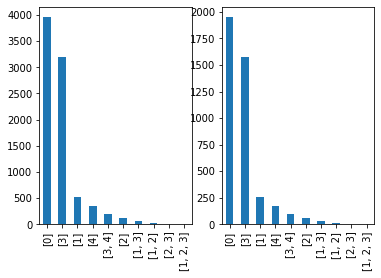

In [115]:
fig, (ax1, ax2) = plt.subplots(1,2)
X_train.ClassId.value_counts().plot(kind='bar', ax=ax1)
X_test.ClassId.value_counts().plot(kind='bar', ax=ax2)